<a href="https://colab.research.google.com/github/Shrey-Viradiya/ML_DL/blob/master/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Jun 19 18:54:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0449-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0450-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0451

In [5]:
!rm -r chest_xray/chest_xray/ -f
!rm -r chest_xray/__MACOSX/ -f

# Convolutional Neural Network to detect Pneumonia


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt #Ploting charts
from glob import glob #retriving an array of files in directories
import tensorflow as tf
from keras.models import Sequential #for neural network models
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D, Lambda
from keras.preprocessing.image import ImageDataGenerator #Data augmentation and preprocessing
from keras.utils import to_categorical #For One-hot Encoding
from keras.optimizers import Adam, SGD, RMSprop #For Optimizing the Neural Network
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Data Analysis and Preprocessing

Getting all images in the dataset

In [8]:
path_train = "./chest_xray/train"
path_val = "./chest_xray/val"
path_test = "./chest_xray/test"

Let's plot some random images
-----------------------------


Text(0.5, 1.0, 'person1159_virus_1946.jpeg')

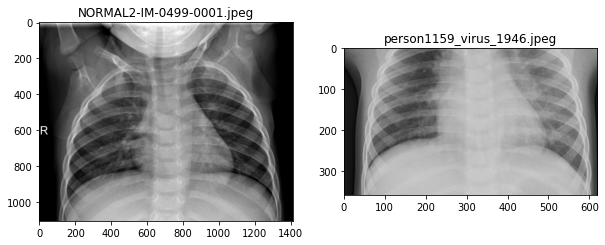

In [9]:
import os
from PIL import Image

print("Let's plot some random images")
print("-----------------------------")

images = os.listdir(path_train+'/NORMAL')
name1 = images[np.random.randint(0,len(images))]
path1 = path_train + "/NORMAL/" + name1

images = os.listdir(path_train+'/PNEUMONIA')
name2 = images[np.random.randint(0,len(images))]
path2 = path_train + "/PNEUMONIA/" + name2

plt.figure(figsize= (10,6))

plt.subplot(121)
plt.imshow(Image.open(path1), cmap='gray')
plt.title(name1)

plt.subplot(122)
plt.imshow(Image.open(path2), cmap='gray')
plt.title(name2)

### Transforming the images
* We're changing the sizes of the images to 226 x 226 and we'll flip the images horizontally as well so that we can have more data(images) to train on.

In [10]:
#Data preprocessing and analysis
classes = ["NORMAL", "PNEUMONIA"]
train_data = glob(path_train+"/NORMAL/*.jpeg")
train_data += glob(path_train+"/PNEUMONIA/*.jpeg")
data_gen = ImageDataGenerator() #Augmentation happens here
#But in this example we're not going to give the ImageDataGenerator method any parameters to augment our data.

In [11]:
train_batches = data_gen.flow_from_directory(path_train, target_size = (226, 226), classes = classes, class_mode = "categorical")
val_batches = data_gen.flow_from_directory(path_val, target_size = (226, 226), classes = classes, class_mode = "categorical")
test_batches = data_gen.flow_from_directory(path_test, target_size = (226, 226), classes = classes, class_mode = "categorical")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [12]:
train_batches.image_shape

(226, 226, 3)

## The Artificial Neural Network

### Model 1
Source to model is [here.](https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3)

In [13]:
#This is a Convolutional Artificial Neural Network
#VGG16 Model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=train_batches.image_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [14]:
#Viewing the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 228, 228, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 226, 226, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 228, 228, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 226, 226, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 113, 113, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 115, 115, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 113, 113, 128)    

In [15]:
optimizer = Adam(lr = 0.0001)
early_stopping_monitor = EarlyStopping(patience = 3, monitor = "val_accuracy", mode="max")
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
history = model.fit(train_batches, epochs=5, callbacks=[early_stopping_monitor], shuffle=True, validation_data=val_batches )
prediction = model.predict(train_batches)
score = model.evaluate(test_batches)

Epoch 1/5
163/163 [==============================] - 65s 401ms/step - loss: 0.3869 - accuracy: 0.8278 - val_loss: 0.4009 - val_accuracy: 0.7500
Epoch 2/5
163/163 [==============================] - 62s 381ms/step - loss: 0.1339 - accuracy: 0.9498 - val_loss: 0.5177 - val_accuracy: 0.7500
Epoch 3/5
163/163 [==============================] - 62s 383ms/step - loss: 0.0839 - accuracy: 0.9661 - val_loss: 0.1441 - val_accuracy: 1.0000
Epoch 4/5
163/163 [==============================] - 63s 384ms/step - loss: 0.0767 - accuracy: 0.9718 - val_loss: 0.7470 - val_accuracy: 0.7500
Epoch 5/5
20/20 [==============================] - 6s 285ms/step


In [16]:
score = model.evaluate(test_batches)

20/20 [==============================] - 6s 284ms/step


In [17]:
score

[0.40564101934432983, 0.7612179517745972]

Model 2

In [18]:
from functools import partial

DefaultConv2D = partial(Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = Sequential([
    DefaultConv2D(filters = 64, kernel_size = 7, input_shape=train_batches.image_shape),
    MaxPooling2D(pool_size=2),
    Lambda(tf.nn.local_response_normalization),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    MaxPooling2D(pool_size=2),
    Lambda(tf.nn.local_response_normalization),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=32, activation='relu'),
    Dropout(0.5),
    Dense(units=2, activation='softmax')
])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience = 5)
history = model.fit(train_batches, callbacks=[early_stopping_monitor], validation_data = val_batches,epochs= 30)

Epoch 1/30
163/163 [==============================] - 58s 357ms/step - loss: 0.4650 - accuracy: 0.7592 - val_loss: 1.1126 - val_accuracy: 0.6250
Epoch 2/30
163/163 [==============================] - 57s 352ms/step - loss: 0.3567 - accuracy: 0.8595 - val_loss: 1.2400 - val_accuracy: 0.5625
Epoch 3/30
163/163 [==============================] - 58s 355ms/step - loss: 0.3128 - accuracy: 0.8859 - val_loss: 1.5098 - val_accuracy: 0.6875
Epoch 4/30
163/163 [==============================] - 57s 348ms/step - loss: 0.2719 - accuracy: 0.8984 - val_loss: 0.5407 - val_accuracy: 0.6875
Epoch 5/30
163/163 [==============================] - 56s 344ms/step - loss: 0.2505 - accuracy: 0.9057 - val_loss: 1.2695 - val_accuracy: 0.6875
Epoch 6/30
163/163 [==============================] - 57s 347ms/step - loss: 0.2235 - accuracy: 0.9156 - val_loss: 0.5012 - val_accuracy: 0.8125
Epoch 7/30
163/163 [==============================] - 57s 348ms/step - loss: 0.1653 - accuracy: 0.9438 - val_loss: 0.8883 - val_ac

In [19]:
score = model.evaluate(test_batches)

20/20 [==============================] - 6s 278ms/step


In [20]:
score

[1.5200800895690918, 0.7644230723381042]